In [1]:
import requests

from bs4 import BeautifulSoup

import pandas as pd

In [2]:
salary_url = 'https://www.spotrac.com/nfl/cap/'

In [3]:
webpage = requests.get(salary_url)

# this returned NaN for 'cap' columns
# salary_data = pd.read_html(webpage.text)[0]
# salary_data.head()

In [4]:
soup = BeautifulSoup(webpage.text)

html_table = soup.find('table')

html_cols = soup.find_all('th')

cols = [col.text for col in html_cols]

#print(cols)

In [5]:
df = pd.DataFrame(columns = cols)

#df

In [6]:
html_data = html_table.find_all('tr')[1:]

for row in html_data:

  html_row_data = row.find_all('td')

  row_data = [data.text.strip() for data in html_row_data]

  if row_data[0] == 'League Average':
    continue

  row_data[1] = row_data[1].split('\n')[0]

  row_data[4] = row_data[4].strip('$').replace(',', '')

  row_data[5] = row_data[5].strip('$').replace(',', '')

  row_data[6] = row_data[6].split('$')[1].replace(',', '')

  row_data[7] = row_data[7].split('$')[1].replace(',', '')

  row_data[8] = row_data[8].split('$')[1].replace(',', '')

  row_data[9] = row_data[9].split('$')[1].replace(',', '')

  length = len(df)

  df.loc[length] = row_data

In [7]:
num_cols = ['Rank', 'Signed', 'Avg Age', 'Active', 'Dead', 'Top 51 Cap', 'Cap Space(Top 51)', 'Total Cap', 'Cap Space(All)']

df['Dead'][df['Dead'] == '0 -'] = 0

df[num_cols] = df[num_cols].apply(pd.to_numeric)

#df.head()

In [8]:
html_team_urls = html_table.find_all('a') #describe yourself

team_url = [url.get('href') for url in html_team_urls]

df['Team URL'] = team_url

#df.tail()

In [9]:


for ind in df.index:

  team_name = df.loc[ind, 'Team']
  team_url = df.loc[ind, 'Team URL']

  team_webpage = requests.get(team_url)

  team_soup = BeautifulSoup(team_webpage.text)

  team_html_table = team_soup.find('table')

  if ind == 0:

    team_html_cols = team_soup.find_all('th')[:13]

    cols = [col.text for col in team_html_cols]

    cols[0] = cols[0][:-5]

    team_df = pd.DataFrame(columns = cols)

  player_html_data = team_html_table.find_all('tr')[1:]

  for row in player_html_data[:-1]:

    html_row_data = row.find_all('td')

    player_row_data = [data.text.strip() for data in html_row_data]

    player_row_data[0] = player_row_data[0].split()

    player_row_data[0] = ' '.join(player_row_data[0][(len(player_row_data[0]) // 2):])

    for i in range(len(player_row_data)-2):

      player_row_data[i+2] = player_row_data[i+2].replace('$', '').replace(',', '').replace('0-', '0').replace('(', '-').replace(')', '').split()[0]

    length = len(team_df)

    team_df.loc[length] = player_row_data

team_df = team_df.loc[:,~team_df.columns.duplicated()].copy()

num_cols = list(team_df.columns[2:])

team_df[num_cols] = team_df[num_cols].apply(pd.to_numeric)

team_df['Pos.'][team_df['Pos.'] == 'WLB'] = 'OLB'

team_df['Pos.'][team_df['Pos.'] == 'OL'] = 'G'

#team_df.head()

#team_df.groupby('Pos.').mean().sort_values('Cap Hit', ascending = False)[['Cap Hit', 'Cap %']]

#team_df.sort_values('Cap Hit', ascending = False).head(5)

# add team name to player df

<ipython-input-9-320bf0242a6b>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_df['Pos.'][team_df['Pos.'] == 'WLB'] = 'OLB'
<ipython-input-9-320bf0242a6b>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_df['Pos.'][team_df['Pos.'] == 'OL'] = 'G'


In [10]:
depth_chart_url = 'https://www.ourlads.com/nfldepthcharts/depthcharts.aspx'

In [11]:
depth_chart_webpage = requests.get(depth_chart_url)

In [12]:
depth_chart_soup = BeautifulSoup(depth_chart_webpage.text)

In [13]:
depth_chart_table_html = depth_chart_soup.find('table')

depth_chart_columns_html = depth_chart_table_html.find_all('th')

depth_chart_cols = [col.text for col in depth_chart_columns_html]

depth_chart_df = pd.DataFrame(columns = depth_chart_cols)

In [14]:
depth_chart_html_data = depth_chart_table_html.find_all('tr')[4:]

for row in depth_chart_html_data:

  html_row_data = row.find_all('td')

  row_data = [data.text.strip() for data in html_row_data]

  length = len(depth_chart_df)

  if(len(row_data) != 12):
    continue

  row_data[3] = row_data[3].split()[:-1]

  row_data[3] = [data.replace(',', '') for data in row_data[3]]

  row_data[3] = row_data[3][-1:] + row_data[3][:-1]

  row_data[3] = ' '.join(row_data[3])

  row_data[3] = row_data[3].title()

  depth_chart_df.loc[length] = row_data

#depth_chart_df.head()

In [15]:
merged_df = team_df.merge(depth_chart_df,
                          left_on = 'Active Players',
                          right_on = 'Player 1')[['Active Players',
                                                  'Pos.',
                                                  'Cap Hit',
                                                  'Base Salary']]

In [16]:
pd.options.display.float_format = '${:,.2f}'.format

average_starter_sal = merged_df[['Pos.', 'Cap Hit', 'Base Salary']].groupby('Pos.').mean().sort_values(by = 'Cap Hit', ascending = False)

average_starter_sal

,Cap Hit,Base Salary
Pos.,,
QB,"$24,070,089.91","$12,224,913.30"
LT,"$16,281,302.00","$9,357,834.59"
ILB,"$12,000,220.44","$7,439,884.06"
RT,"$10,852,127.74","$5,809,282.09"
SS,"$9,522,239.12","$6,118,330.41"
FS,"$9,251,354.75","$6,082,666.81"
OLB,"$9,224,649.09","$4,425,554.74"
DE,"$8,663,176.98","$4,712,911.56"
DT,"$8,361,302.13","$5,027,522.74"


<Axes: title={'center': 'Average Starter Salary by Position'}, xlabel='Pos.'>

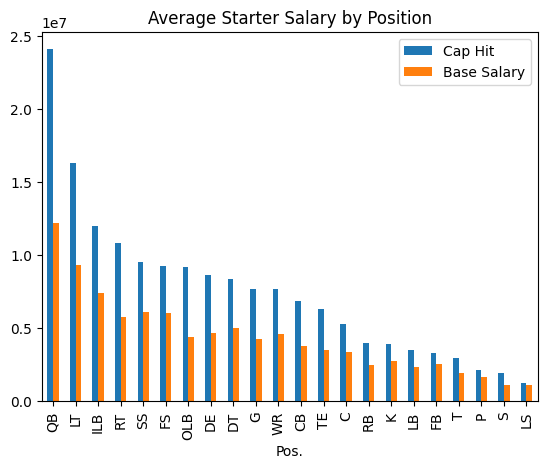

In [17]:
average_starter_sal.plot.bar(y = ['Cap Hit', 'Base Salary'], title = 'Average Starter Salary by Position')